# Analysis

In [1]:
import torch
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%cd ../

D:\Geoff Liu Lab\ml4oncology_github\PredUCE


In [2]:
from scripts.train_pipeline import *
from src.util import (
    plot_repeated_corr_matrix,
    prepare_event_rate_dfs,
    arrows_plot,
    analyze_model_performance,
    plot_performance_curves,
    plot_calibration_curves,
    plot_ecdf,
    plot_net_benefit_curves,
    plot_radar_chart,
    create_forest_plot
)
from src.run_shap import (
    load_results,
    generate_shaps,
    shap_plots,
    calculate_mean_shap_values,
    plot_mean_abs_shap_values
)
from src.config import (
    data_path_dict,
    label_mapping,
    legend_order
)

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import colorcet as cc

# Loading datasets
train_df = pd.read_csv(data_path_dict["train"])
tune_df = pd.read_csv(data_path_dict["tune"])
test_df = pd.read_csv(data_path_dict["test"])
df = pd.read_csv(data_path_dict["full"])

# Loading train results
train_results = load_results(data_path_dict["train_results"])
results_df = pd.DataFrame.from_dict(train_results, orient='index').rename_axis(['model', 'label']).reset_index()

# Load features file
temporal_cohort_sheet = pd.read_excel(data_path_dict["features_file"], sheet_name=data_path_dict["sheet_name"])

# Setup for labels and plotting
labels_list = [s for s in train_df.columns if s.startswith("Label") and s.endswith("3pt_change")]

# Pre-define colors based on the legend order
colors = cc.glasbey_light[:len(legend_order)]

# print success message
print("Data and results loaded successfully!")

D:\anoconda\envs\aim2reduce\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Data and results loaded successfully!


## 1.Correlation Plot

Correlation between Pain and Fatigue: 0.2273
Correlation between Pain and Nausea: 0.1761
Correlation between Pain and Depression: 0.1813
Correlation between Pain and Anxiety: 0.1276
Correlation between Pain and Drowsiness: 0.1677
Correlation between Pain and Appetite: 0.1488
Correlation between Pain and Well-being: 0.2239
Correlation between Pain and Dyspnea: 0.1169
Correlation between Fatigue and Nausea: 0.1821
Correlation between Fatigue and Depression: 0.2329
Correlation between Fatigue and Anxiety: 0.2184
Correlation between Fatigue and Drowsiness: 0.4574
Correlation between Fatigue and Appetite: 0.2602
Correlation between Fatigue and Well-being: 0.3119
Correlation between Fatigue and Dyspnea: 0.2276
Correlation between Nausea and Depression: 0.1560
Correlation between Nausea and Anxiety: 0.1184
Correlation between Nausea and Drowsiness: 0.2581
Correlation between Nausea and Appetite: 0.3075
Correlation between Nausea and Well-being: 0.2055
Correlation between Nausea and Dyspnea: 0

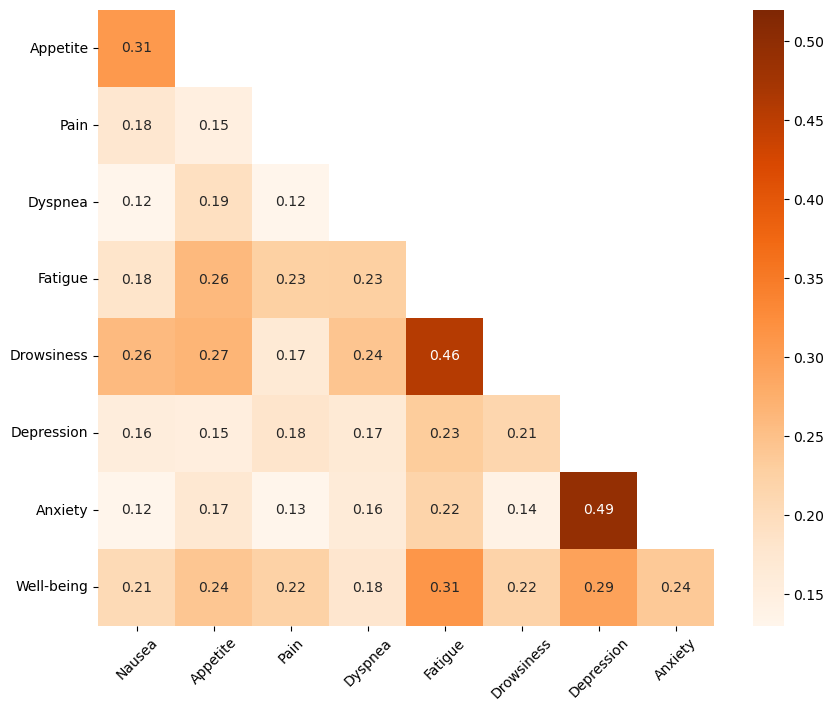

In [3]:
dev_cohort = pd.concat([train_df, tune_df], axis=0)
corr_matrix = plot_repeated_corr_matrix(dev_cohort, labels_list, label_mapping, legend_order)

## 2.10% Alarm rate for each & all events

In [4]:
merge_df, ten_percent_per_event_df, ten_percent_all_event_df, start_values = prepare_event_rate_dfs(test_df, results_df, labels_list, 'lgbm', label_mapping, legend_order, alarm_rate=0.1)

The threshold that achieves a 10.0% alarm rate is 0.41013671223741244


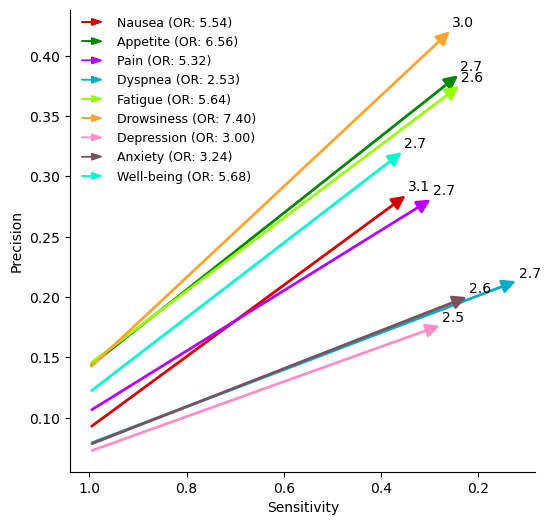

In [5]:
symptoms_odds_ratio = pd.read_csv(data_path_dict['symptoms_odd_ratio_file'], index_col=0).reindex(legend_order)
# Plot the 10% alarm rate for each event
arrows_plot([ten_percent_per_event_df], colors, legend_order, start_values_list=[None], invert_xaxis=True, show_text=True,ed_odds_ratio=symptoms_odds_ratio)

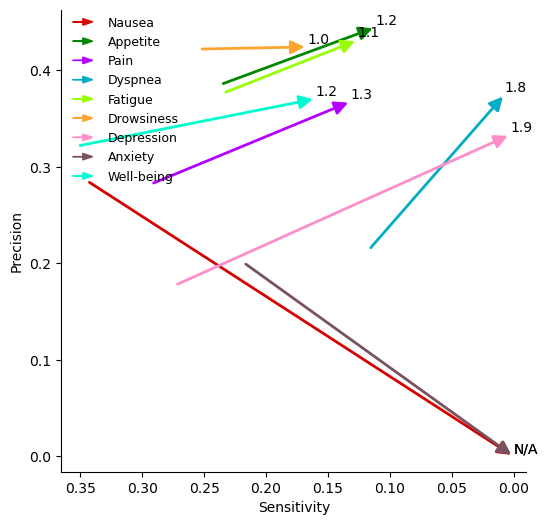

In [6]:
# Plot the 10% alarm rate for all events
arrows_plot([ten_percent_all_event_df], colors, legend_order, start_values_list=[start_values], invert_xaxis=True, show_text=True)

## 3.AUROC, AUPRC, Calibration and Cumulative probability curves.

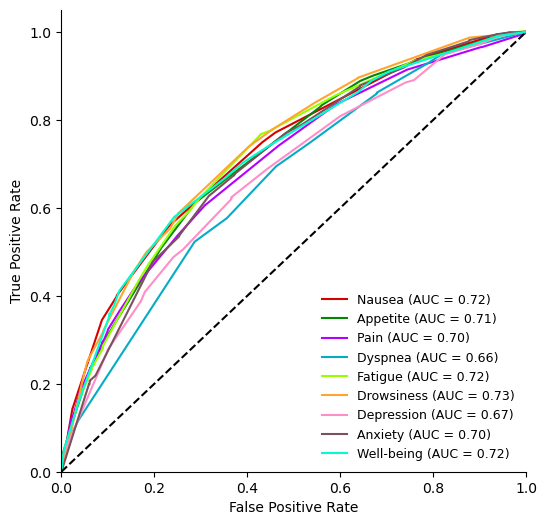

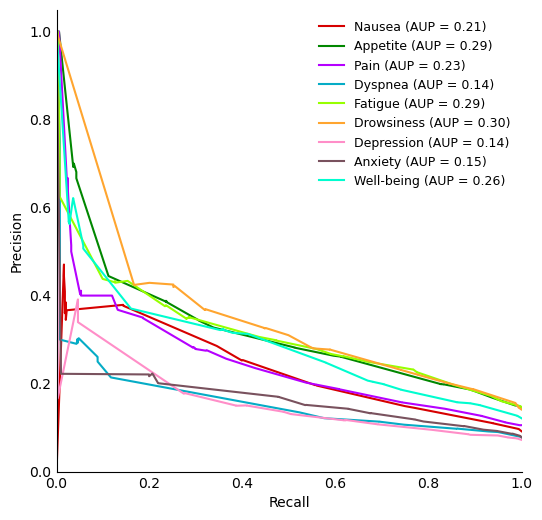

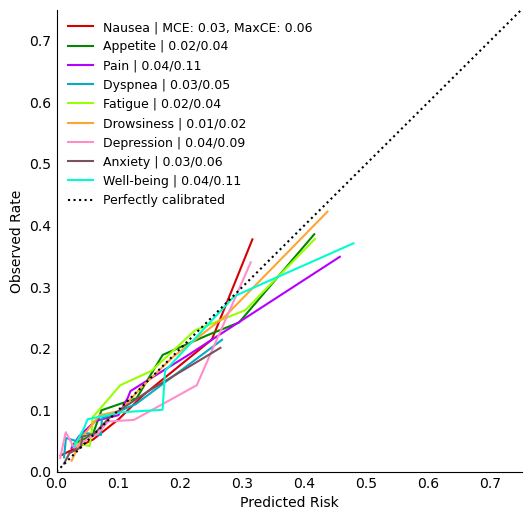

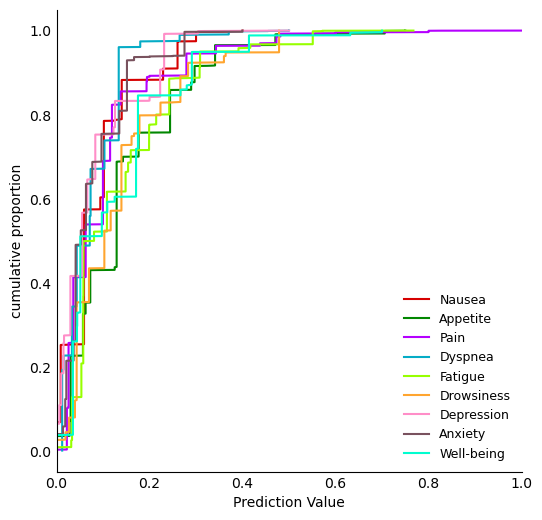

In [7]:
metrics = analyze_model_performance(results_df, labels_list, 'lgbm')
plot_performance_curves(metrics, labels_list, label_mapping, legend_order, colors)
plot_calibration_curves(metrics['calibration_curves'], labels_list, label_mapping, legend_order, colors)
plot_ecdf(merge_df, label_mapping, legend_order, colors)

## 4.Net benefits

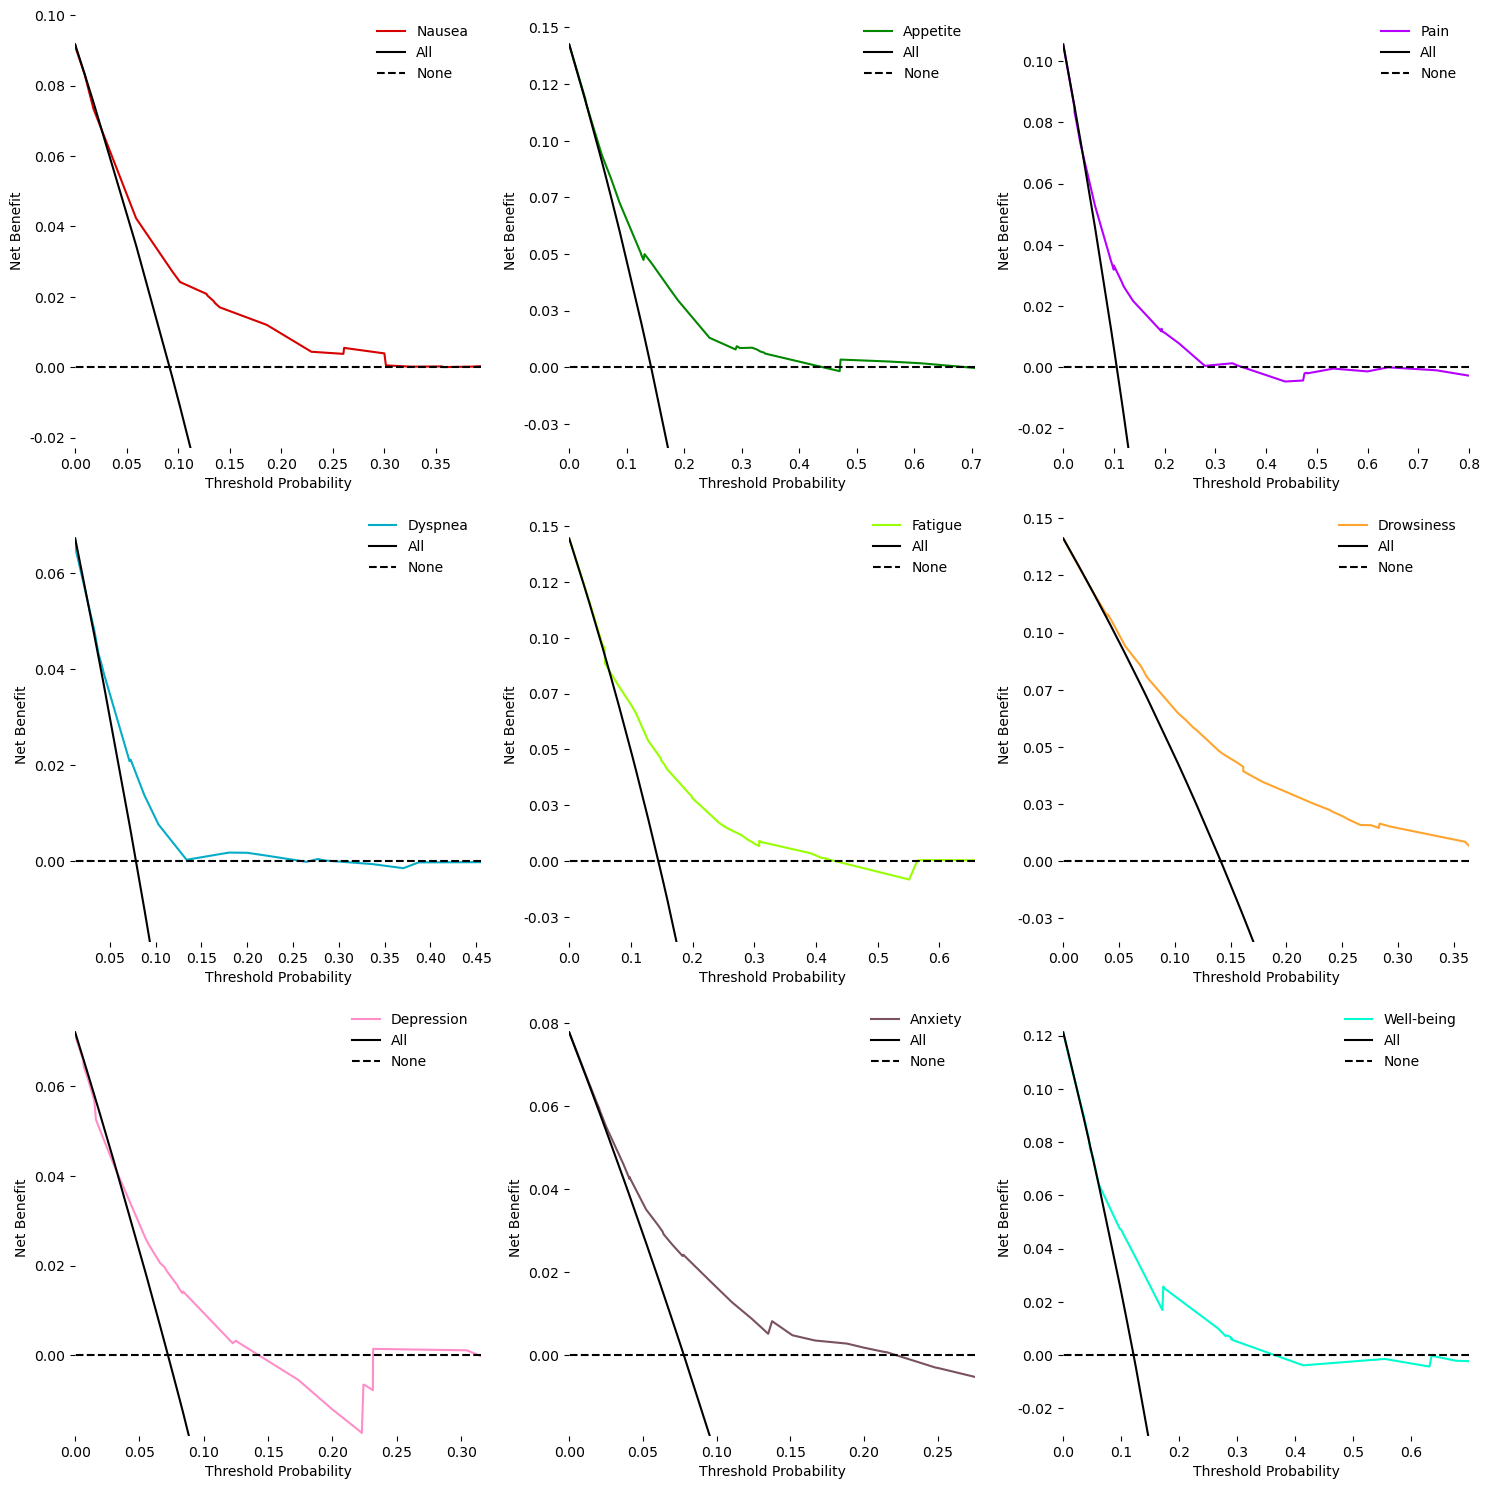

In [9]:
# plot net benefit curves
plot_net_benefit_curves(metrics['net_benefit_df'], labels_list,label_mapping, legend_order,colors)

## 5.SHAP

In [251]:
shap_dict = generate_shaps(test_df, labels_list,data_path_dict['features_file'],data_path_dict['sheet_name'],train_results, data_path_dict['plots_save_path'])

 97%|=================== | 5414/5570 [00:21<00:00]       

Finished SHAP value calculation and column renaming.


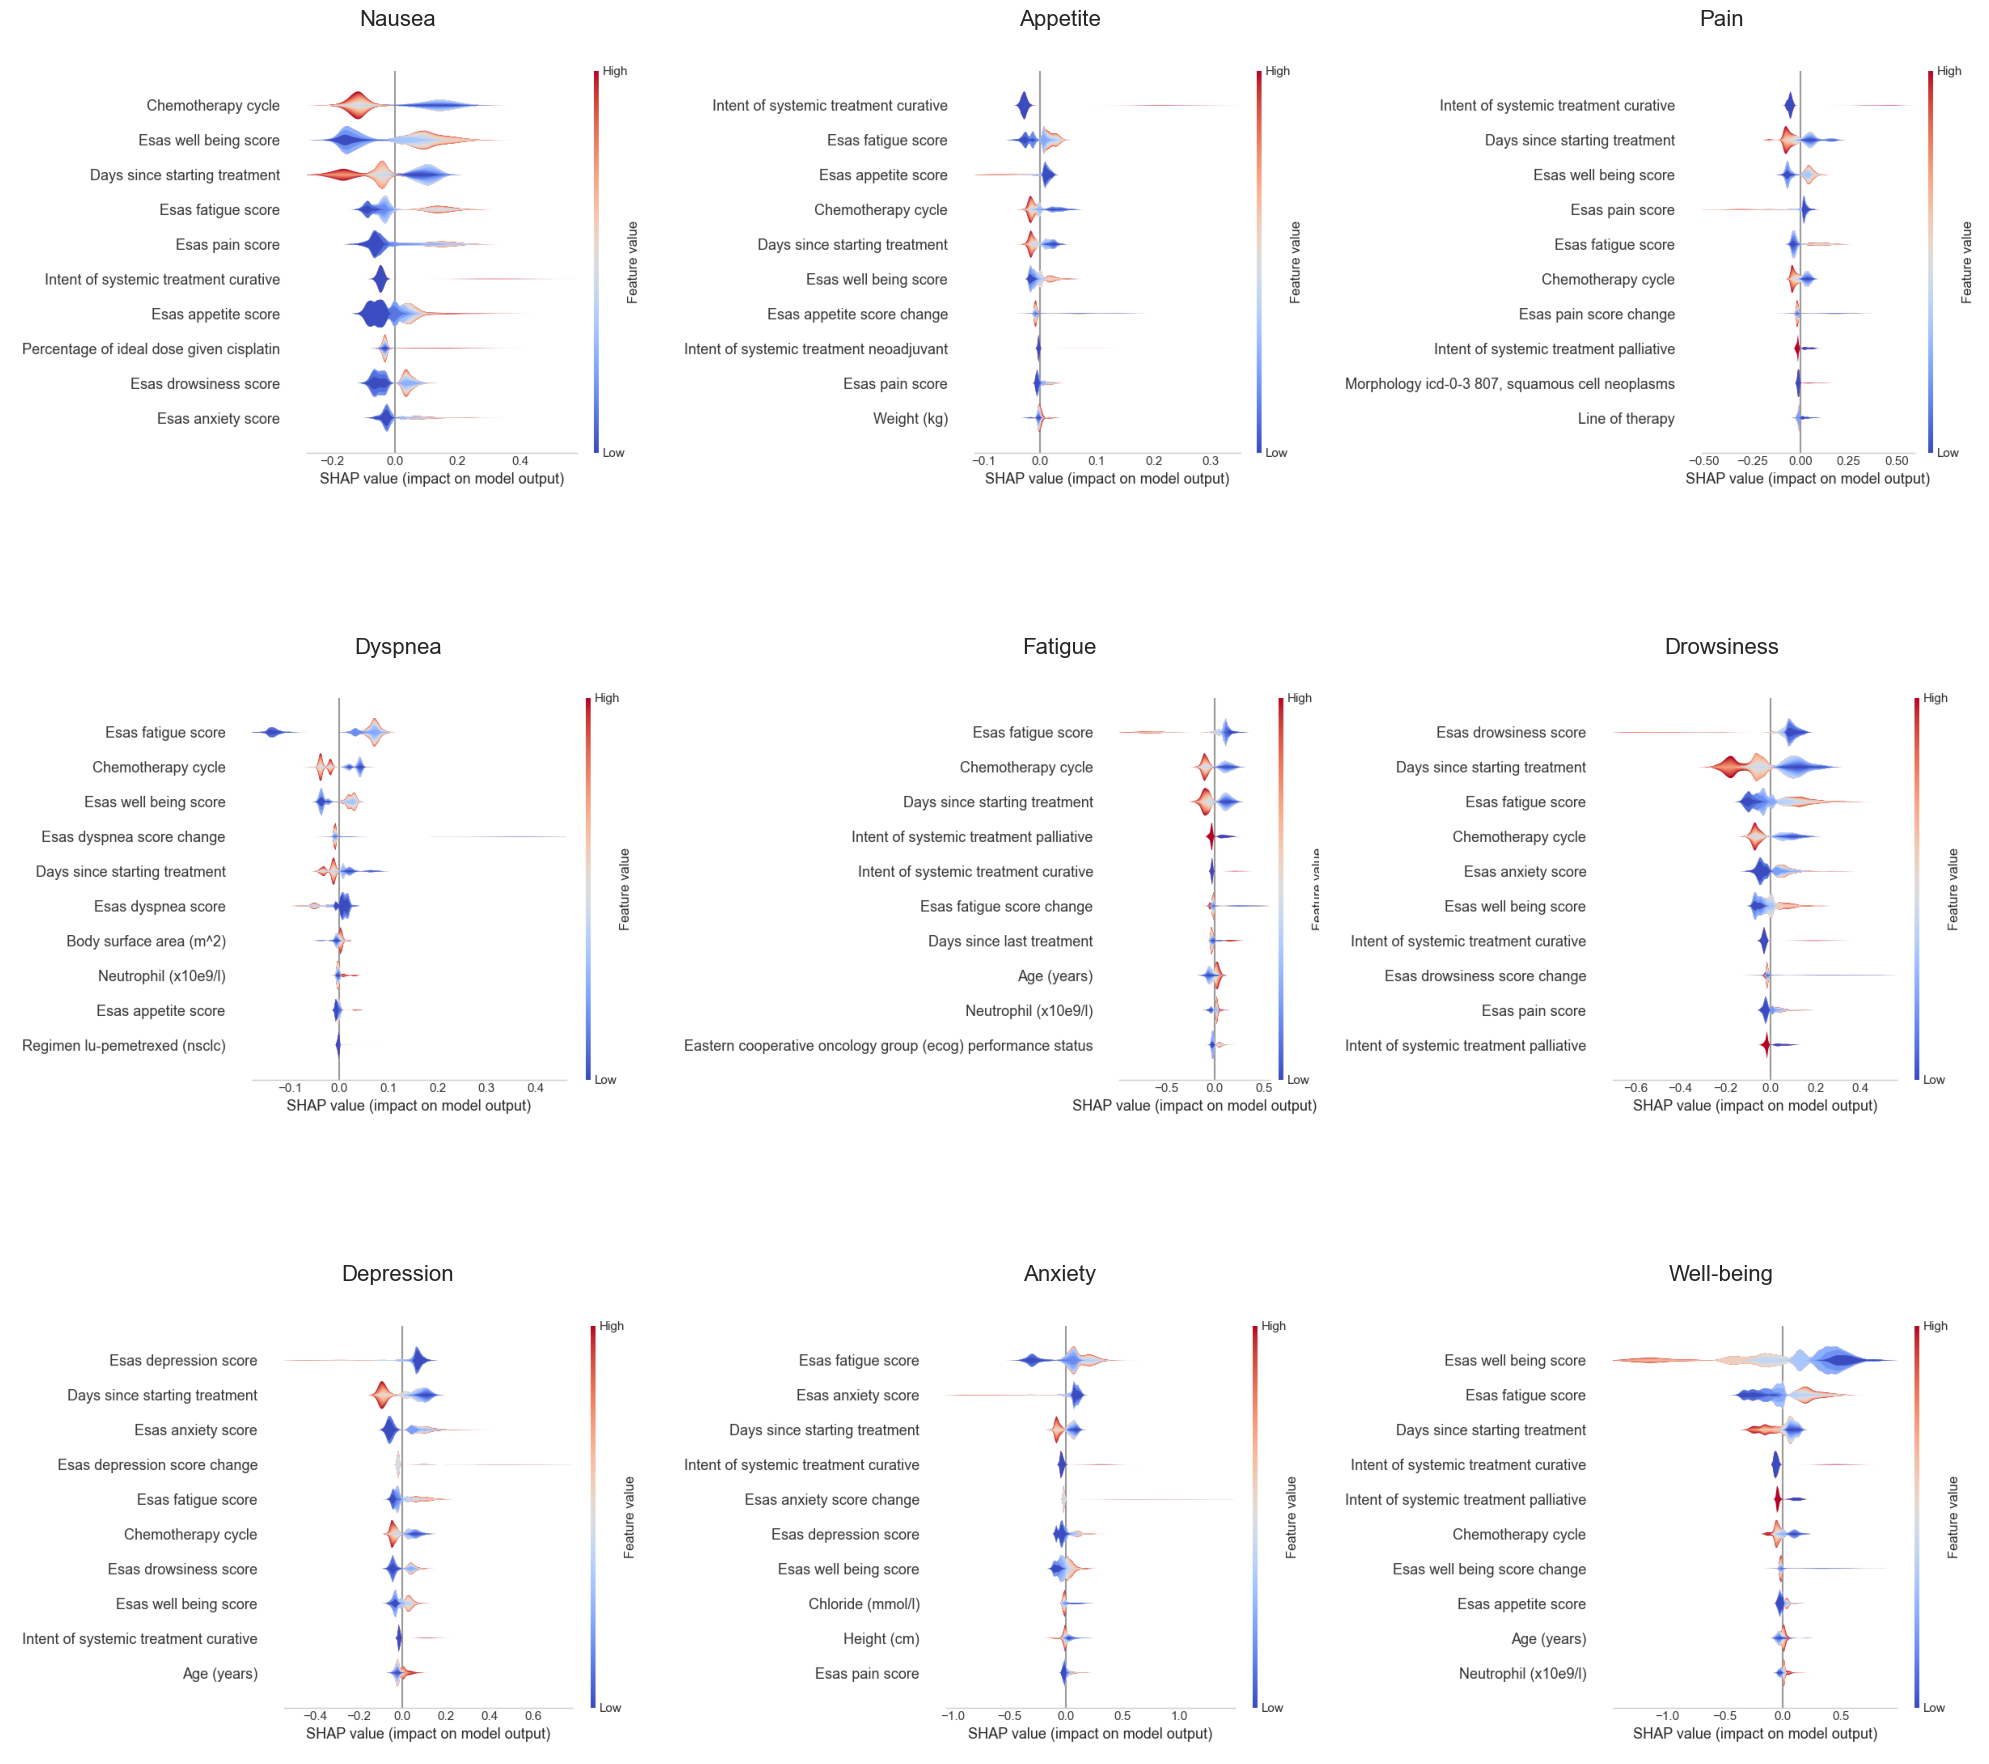

In [252]:
# Plot the SHAP violin plots
shap_plots(data_path_dict['plots_save_path'], legend_order, label_mapping, plot_type="layered_violin")

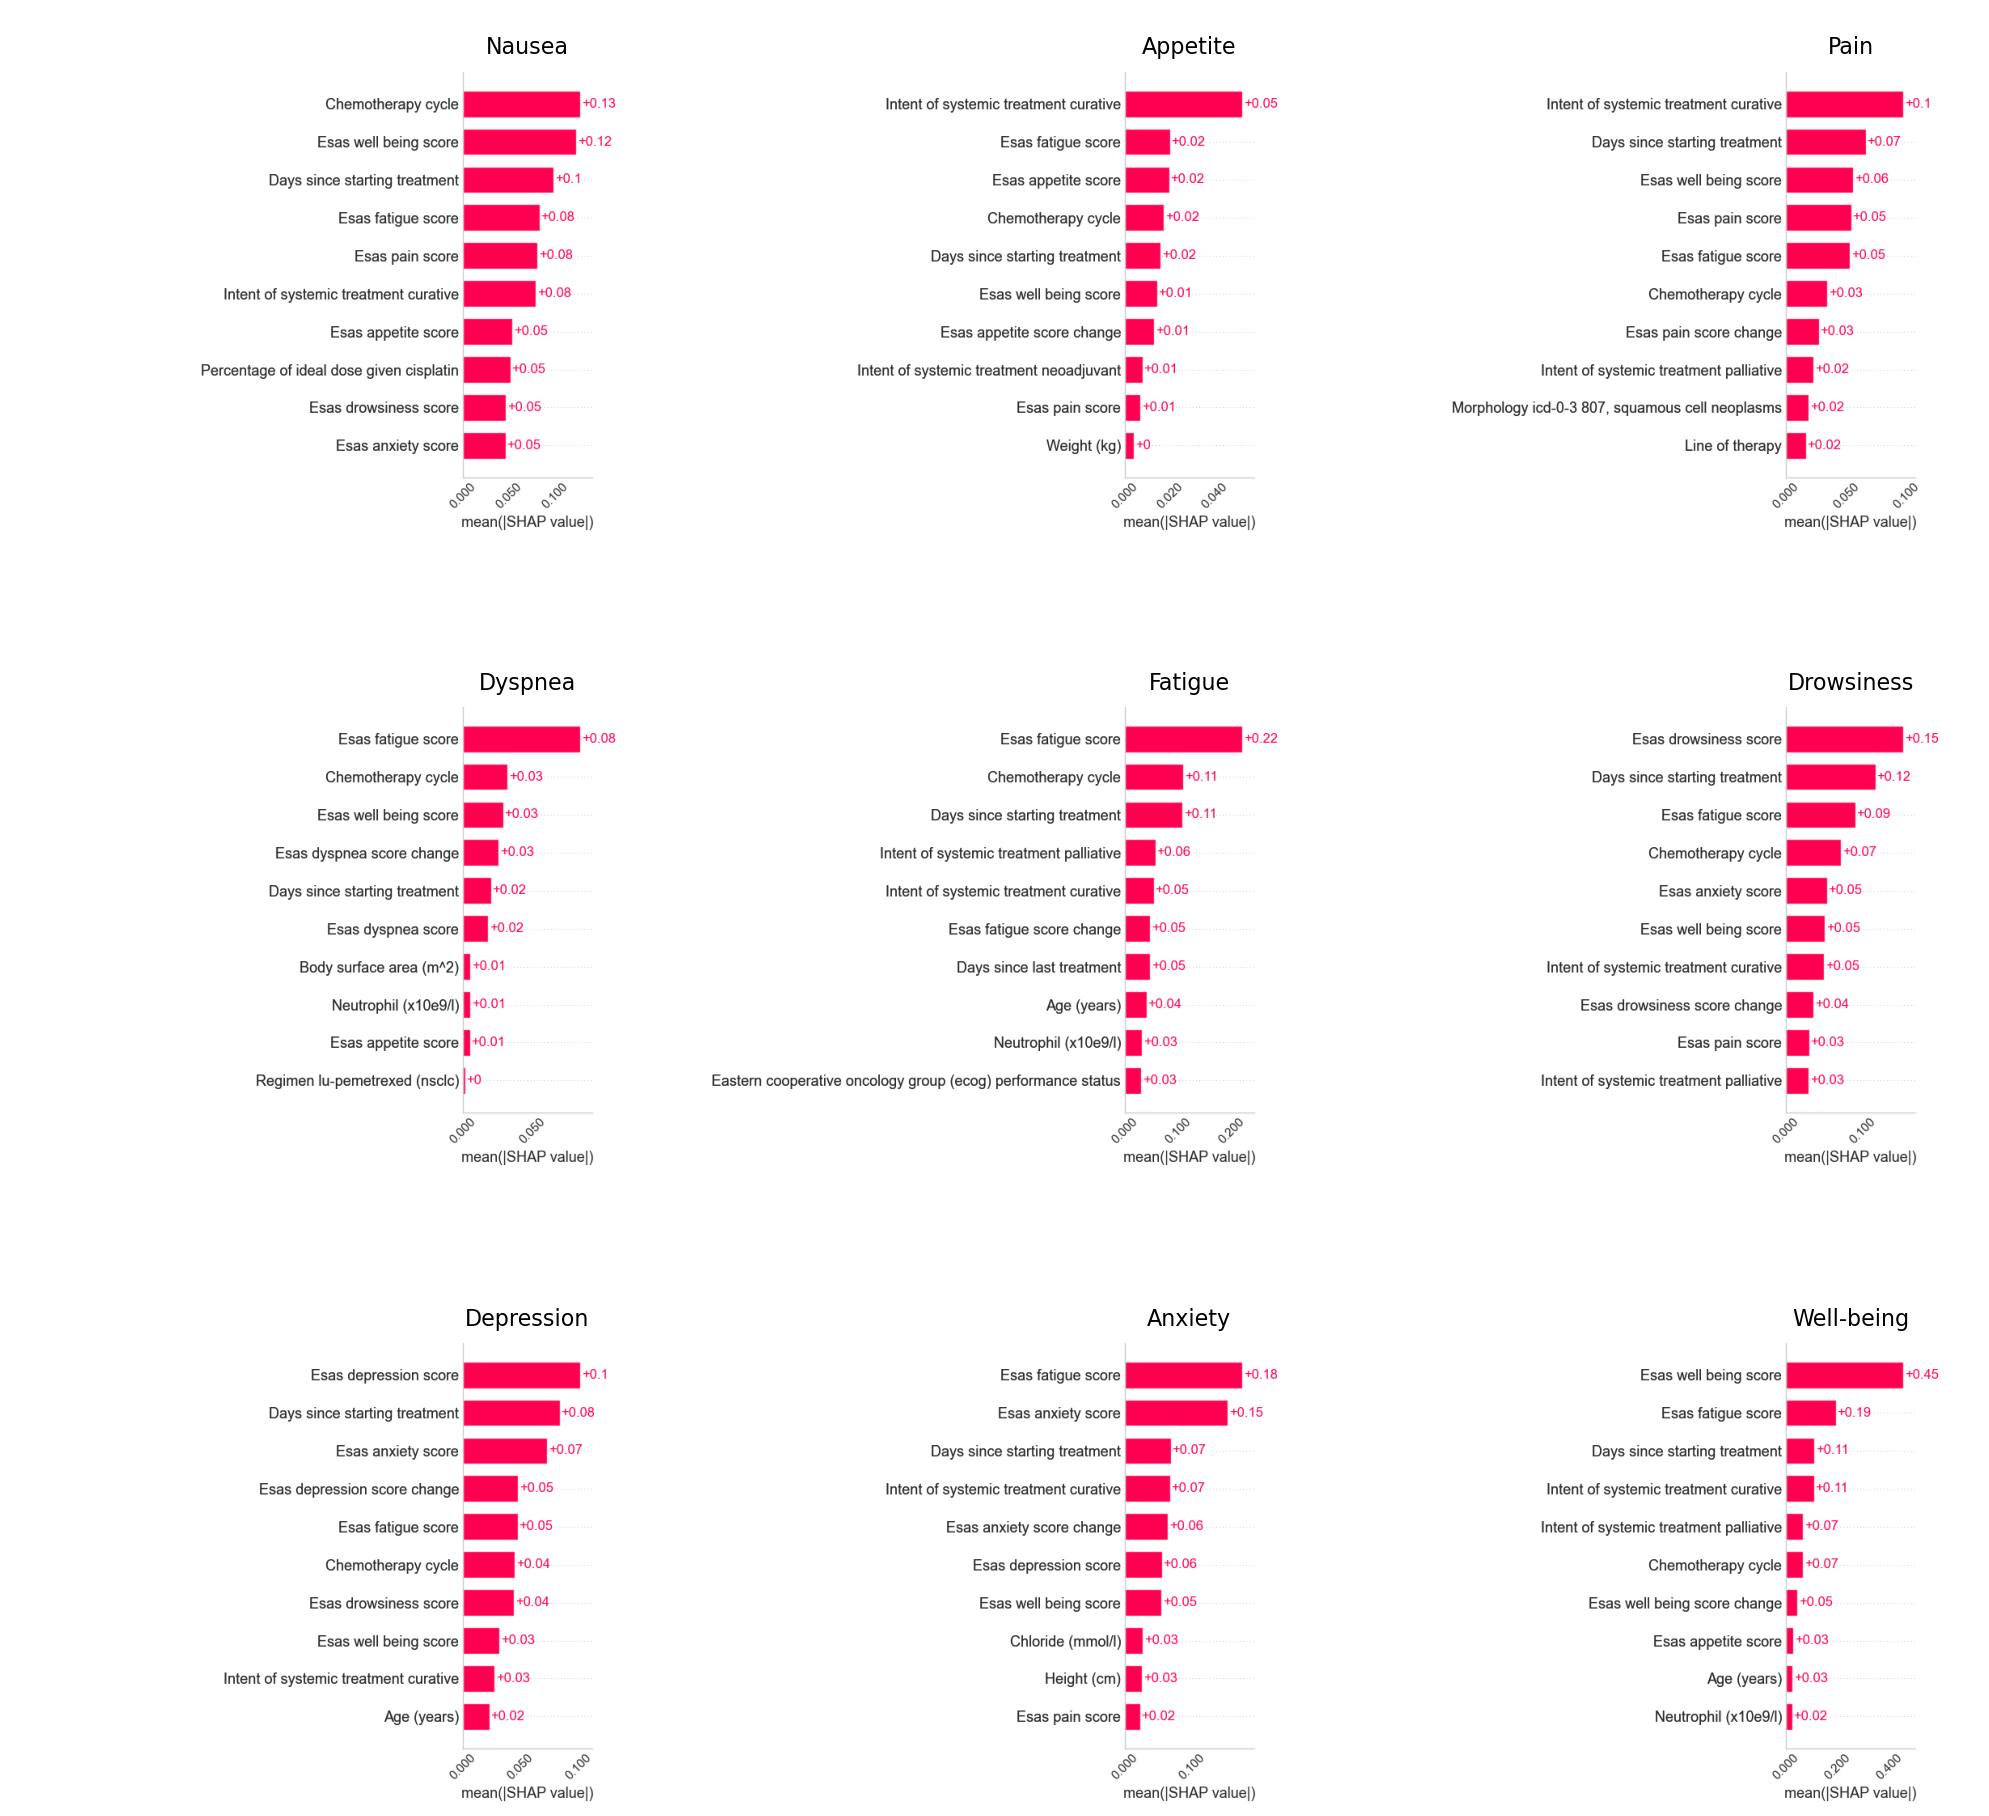

In [369]:
# Plot SHAP bar plots
shap_plots(data_path_dict['plots_save_path'], legend_order, label_mapping, plot_type="bar")

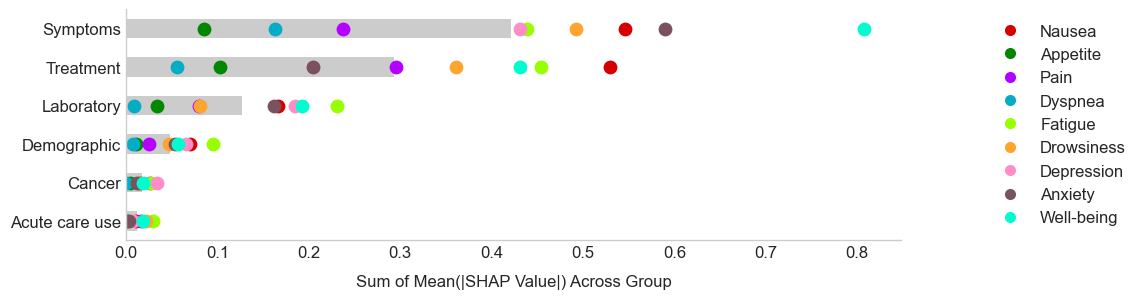

In [254]:
# Plot sum of mean SHAP across group
mean_shap_df = calculate_mean_shap_values(shap_dict, labels_list, test_df, label_mapping, legend_order, temporal_cohort_sheet)
plot_mean_abs_shap_values(mean_shap_df, temporal_cohort_sheet, colors)

## 6. Radar Plot

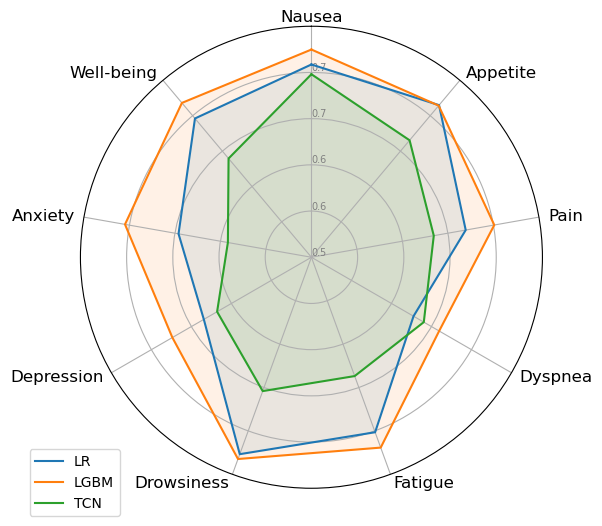

In [396]:
result_pivot = results_df.pivot(index='label', columns='model', values='train_auroc').rename(index=label_mapping).reindex(legend_order)
model_list = {'lr': 'LR', 'lgbm': 'LGBM', 'mtl_tcn': 'TCN'}
# Example usage with 90 degrees rotation:
plot_radar_chart(result_pivot, model_list, start_from=0.5, end_at=0.75, scale =0.05 ,rotation_degrees=125, label_font_size=12)

## 7. ED odds ratio

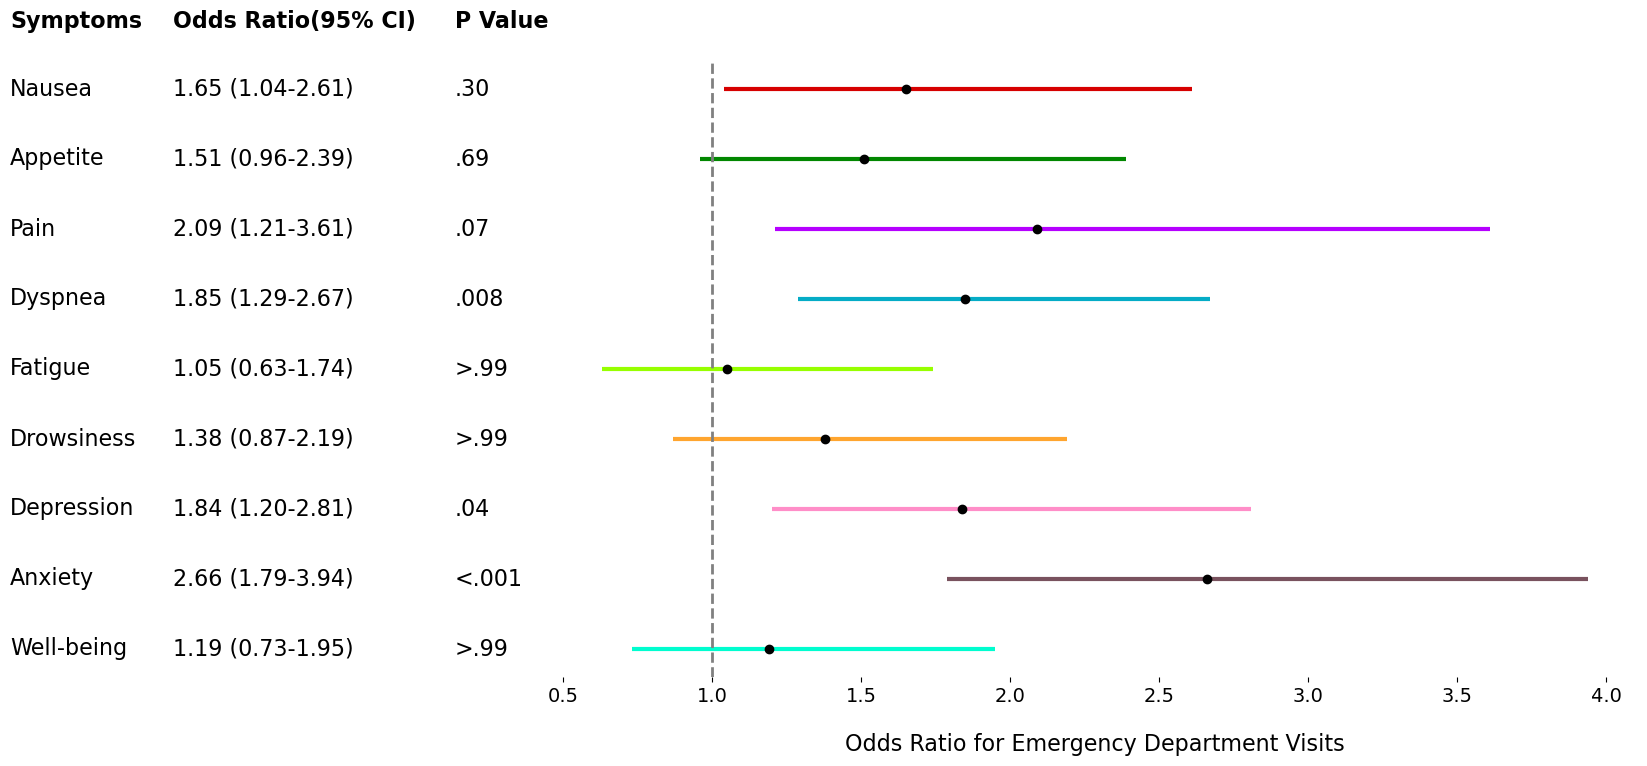

In [406]:
# Load the odds ratio data and reindex according to legend_order in one line
ed_odds_ratio = pd.read_csv(data_path_dict['ed_odd_ratio_file'], index_col=0).reindex(legend_order)
# Create the forest plot using the loaded and reindexed data
create_forest_plot(ed_odds_ratio, colors)